<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Optimitzaci%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

d= [1.52026937e+11 1.52027369e+11 1.52027799e+11 ... 1.52023337e+11
 1.52023697e+11 1.52024057e+11]


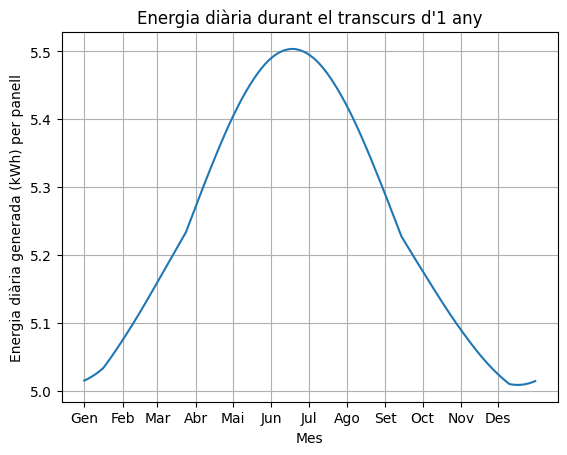

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from datetime import date, timedelta

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos):
  pos = cos[:3]*(1/r0)*10**3
  vel = cos[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
posicions= np.array([pos_sol, pos_terra, pos_lluna])
velocitats= np.array([vel_sol, vel_terra, vel_lluna])

def acceleracions(pos, masses): # pos és una matriu de N files i 3 columnes
    N= len(masses) # Nombre de cossos: planetes, el Sol i la Lluna
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

t_f = 365
dt = 1/24
hores= int(t_f/dt)
passos = hores +5  #per tenir en compte que un any dura 365 dies i 6 hores afegim 5 + CI = 6 hores "extres" als 365 dies calculats
#AIXÒ ENS DONA L'HORA JUST ABANS DE RETORNAR A LES CONDICIONS INICIALS. SI VOLEM TROBAR EL MOMENT DEL QUE HEM PARTIT PERO UN ANY DESPRÉS HEM DE POSAR EL TEMPS SEGÜENT ÉS A DIR UN + 6

pos_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos):
  pos_nou, vel_nou = rk4(pos_hist[i], vel_hist[i], masses, dt)
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

# Volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/23.9344444 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

# En aquesta part primer definirem el vector b
x = np.array([0])
y = np.array([R_t*np.cos(phi-theta)])
z = np.array([R_t*np.sin(phi-theta)])

# Per, a continuació, rotar respecte l'eix x aquest vector un angle alpha (la inclinació dels panells respecte la horitzontal)
alpha=30
x_alpha=x
y_alpha=y*np.cos(alpha*np.pi/180)+z*np.sin(alpha*np.pi/180)
z_alpha=z*np.cos(alpha*np.pi/180)-y*np.sin(alpha*np.pi/180)

t = np.linspace(0,passos,passos+1)

v = np.array([x_alpha[0], y_alpha[0], z_alpha[0]])
k = np.array([0, np.sin(theta), np.cos(theta)])

def rodrigues(v, k, omega_t):
    v = np.asarray(v)
    k = np.asarray(k)
    k = k / np.linalg.norm(k)
    v_ampliat = v[:, np.newaxis] # Fa que cada component dels vectors sigui un array, per poder operar amb omega_t
    k_ampliat = k[:, np.newaxis]
    return v_ampliat * np.cos(omega_t) + np.cross(k, v)[:, np.newaxis] * np.sin(omega_t) + k_ampliat * np.dot(k, v) * (1 - np.cos(omega_t))
v_prima=rodrigues(v,k,vel_ang*t)

# Aquestes són les coordenades del vector centre terra-bellaterra durant el temps que considerem més condicions inicials
X_b = v_prima[0]
Y_b = v_prima[1]
Z_b = v_prima[2]

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)

mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
Mod_b = np.sqrt(X_b**2 + Y_b**2 + Z_b**2)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)
cos_llista = np.clip(cos_llista, -1.0, 1.0)  # Per evitar problemes numèrics degut a que farem servir la funció arcosinus

temps = np.linspace(0,passos,passos+1)

theta_llista = np.pi - np.arccos(cos_llista) #obtenim l'angle complementari que és el que ens interessa.
theta_llista_g = theta_llista *  360/ (2 * np.pi)

horitzo = 90-(theta_llista)*360/(2*np.pi)

h = 1/24
passos = int(365/h) + 5
passos_planetes = passos

traj_rk4 = np.zeros((passos_planetes + 1, len(masses), 3))
vel_rk4 = np.zeros((passos_planetes + 1, len(masses), 3))

pos = posicions.copy()
vel = velocitats.copy()

traj_rk4[0] = pos
vel_rk4[0] = vel

for k_step in range(passos_planetes):
    pos, vel = rk4(pos, vel, masses, h)
    traj_rk4[k_step + 1] = pos
    vel_rk4[k_step + 1] = vel

idx_sol = 0
idx_terra = 1

latitud = 41.50320 * np.pi / 180   # Latitud Bellaterra en radians

def unit(v):
    n = np.linalg.norm(v)
    return v / n

def rodrigues_vec(v, k, theta):
    k = unit(k)
    return (v * np.cos(theta) + np.cross(k, v) * np.sin(theta) + k * np.dot(k, v) * (1 - np.cos(theta)))

r_rel0 = traj_rk4[0, idx_terra] - traj_rk4[0, idx_sol]
v_rel0 = vel_rk4[0, idx_terra] - vel_rk4[0, idx_sol]
normal_orb = unit(np.cross(r_rel0, v_rel0))
sol_inici = unit(traj_rk4[0, idx_sol] - traj_rk4[0, idx_terra])
eix_incl = unit(np.cross(normal_orb, sol_inici))

obliq = 23.44 * np.pi / 180
eix_rot_mes = unit(rodrigues_vec(normal_orb, eix_incl, +obliq))
eix_rot_menys = unit(rodrigues_vec(normal_orb, eix_incl, -obliq))
eix_rotacio = eix_rot_mes if np.dot(sol_inici, eix_rot_mes) > np.dot(sol_inici, eix_rot_menys) else eix_rot_menys
periode_dia = 24 * 3600
dt_local = h * periode_dia
omega = 2 * np.pi / periode_dia

def derivada_vector(t_val, v_val):
    return omega * np.cross(eix_rotacio, v_val)

def pas_rk4(derivada, t_val, v_val, dt_val):
    k1 = derivada(t_val, v_val)
    k2 = derivada(t_val + 0.5 * dt_val, v_val + 0.5 * dt_val * k1)
    k3 = derivada(t_val + 0.5 * dt_val, v_val + 0.5 * dt_val * k2)
    k4 = derivada(t_val + dt_val, v_val + dt_val * k3)
    return v_val + (dt_val / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

ref = np.array([0.0, 0.0, 1.0])
if np.linalg.norm(np.cross(ref, eix_rotacio)) < 1e-10:
    ref = np.array([0.0, 1.0, 0.0])
e1 = unit(np.cross(ref, eix_rotacio))
normal_inicial = unit(np.cos(latitud) * e1 + np.sin(latitud) * eix_rotacio)

temps_dia = np.zeros(int(periode_dia / dt_local) + 1)
normal_dia = np.zeros((int(periode_dia / dt_local) + 1, 3))

t_val = 0.0
v_val = normal_inicial.copy()

for i in range(int(periode_dia / dt_local) + 1):
    normal_dia[i] = v_val / np.linalg.norm(v_val)
    temps_dia[i] = t_val
    if i < int(periode_dia / dt_local):
        v_val = pas_rk4(derivada_vector, t_val, v_val, dt_local)
        v_val = v_val / np.linalg.norm(v_val)
        t_val += dt_local

dies = 365
h = 1/24

r_S=traj_rk4[:, 0, :]
r_T=traj_rk4[:, 1, :]
r_ST=r_T-r_S
d_normalitzada = np.linalg.norm(r_ST, axis=1) # axis=1 fa que calculi la norma del vector diferència de posicions a cada temps
d=d_normalitzada*r0

print("d=",d)
angle_incidencia_panells=(horitzo+alpha)*np.pi/180

I_rebuda_terra = (695508000**2 / d**2) * 0.99 * 5.670374419 * 10**(-8) * 5778**4 * np.maximum(0, np.sin(angle_incidencia_panells))

area_panell = 2
pot_max = 400
irr_saturacio = 1000

dt_energia = h * periode_dia

pot = pot_max * (I_rebuda_terra / irr_saturacio)
pot = np.minimum(pot, pot_max)

hores_dia = int(1/h)
hores_simulacio = len(pot)
dies_simulacio = hores_simulacio // hores_dia
pot_reshaped = pot[:dies_simulacio * hores_dia].reshape(dies_simulacio, hores_dia)

energia_diaria_kWh = np.sum(pot_reshaped, axis=1) * dt_energia / 3.6e6
energia_panell_any_kWh = np.sum(energia_diaria_kWh)

data_inici_simulacio= date(2025, 6, 21)
dates= [data_inici_simulacio + timedelta(days=i) for i in range(365)]
idx_jan1= None
for i, d_date in enumerate(dates):
    if d_date.month == 1 and d_date.day == 1:
        idx_jan1= i
        break
if idx_jan1 is not None:
    energia_diaria_kWh_plot= np.roll(energia_diaria_kWh, -idx_jan1)
else:
    energia_diaria_kWh_plot= energia_diaria_kWh

# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh_plot)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària generada (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()


Energia anual per panell (kWh/any): 1913.5432412554196
Panells òptims per cobrir l'objectiu: 1.8290676293804329


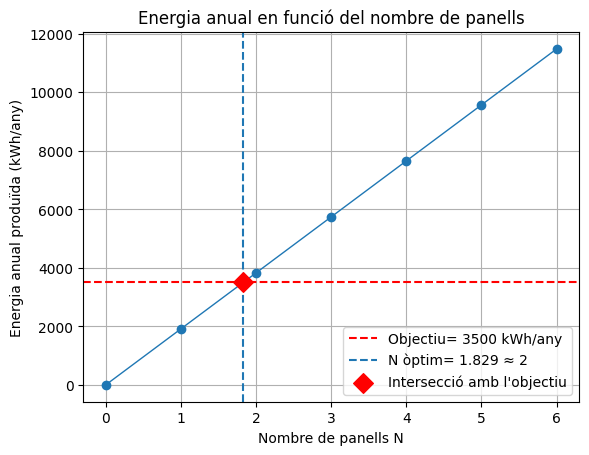

Alpha òptim (inclinació)= 40.8°
Energia anual màxima per panell= 1069.9 kWh/any


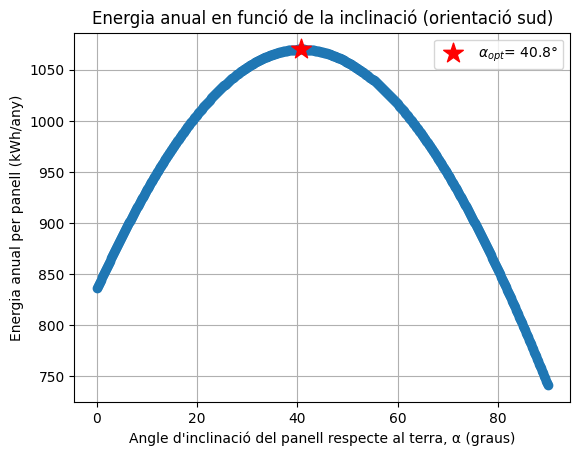

In [16]:

# Nombre òptim de panells

objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(np.ceil(N_optim))

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} \u2248 {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.grid(True)
plt.legend()
plt.show()

energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde= eix_rotacio.copy()

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u= -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma= np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia= np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i]= sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J= 0.0
    n_panell_dia= (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)
    # Normalitzem
    normes= np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia= n_panell_dia / normes[:, None]

    # angle d'incidència: fem servir el producte escalar entre normal del panell i la direcció Terra->Sol, hora a hora
    steps_per_day= int(round(1.0/h))  # Use h for dt_planetes

    R_t = 6371000  #metres

    for dia_any in range(1, 366):
        k0= (dia_any - 1) * steps_per_day

        # Direcció del Sol (Terra -> Sol) cada hora del dia
        st_h= np.zeros((steps_per_day, 3))
        for hh in range(steps_per_day):
            idx= min(k0 + hh, traj_rk4.shape[0]-1)
            rS= traj_rk4[idx, idx_sol]
            rE= traj_rk4[idx, idx_terra]
            st_h[hh]= r0 * (rS - rE)

        mod_st= np.linalg.norm(st_h, axis=1)

        # Normal del panell cada hora (agafem 24 punts; el 25è és t=24h que repetiria)
        b_h= R_t * n_panell_dia[:steps_per_day]
        mod_b= np.linalg.norm(b_h, axis=1)

        cos_inc= np.sum(b_h * st_h, axis=1) / (mod_b * mod_st)
        cos_inc= np.clip(cos_inc, -1.0, 1.0)
        cos_inc= np.maximum(0.0, cos_inc)

        irr_perp= irr_saturacio * cos_inc
        pot= pot_max * (irr_perp / irr_saturacio)
        pot= np.minimum(pot, pot_max)

        energia_dia_J= np.sum(pot) * dt_local # Use dt_local which is h*periode_dia in seconds
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Possibles angles d'inclinació respecte al terra (alpha) amb orientació sud
pas_alpha= 0.2
alphas_graus= np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad= alphas_graus * np.pi / 180

energia_any_alpha= np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim
idx_max= np.argmax(energia_any_alpha)
alpha_optim_graus= alphas_graus[idx_max]
energia_max_kWh_any= energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació)= {alpha_optim_graus:.1f}°")
print(f"Energia anual màxima per panell= {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, \u03B1 (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
#AQUEST JA NO SERVEIX
import numpy as np
import matplotlib.pyplot as plt
import copy
from datetime import date, timedelta

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])
mart= np.array([-2.457240245390437E+08, -2.253913894859833E+07, 5.577461384361338E+06, 3.057555929366051E+00, -2.206677199548648E+01, -5.372712135532627E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic a partir de les dues constants anteriors

def normalitza(cos): # Primer passem a m i m/s, després normalitzem
  pos= cos[:3] * 1e3 / r0
  vel= cos[3:] * 1e3 * (t0 / r0)
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0, m_mart/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
pos_mart, vel_mart= normalitza(mart)
posicions= np.array([pos_sol, pos_terra, pos_lluna, pos_mart])
velocitats= np.array([vel_sol, vel_terra, vel_lluna, vel_mart])

def acceleracions(pos, masses): # pos és matriu N files i 3 columnes
    N= len(masses) # Nombre de planetes
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def euler(pos, vel, masses, h):
    acc_euler= acceleracions(pos, masses)
    vel_nou= vel + h * acc_euler
    pos_nou= pos + h * vel
    return pos_nou, vel_nou

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

# Apliquem aquestes funcions a una simulació de duració 1 any terrestre
dies= 365
h= 1/240
passos= int(dies/h)
trajectoria_euler= np.zeros((passos+1, 4, 3))
trajectoria_rk4  = np.zeros((passos+1, 4, 3))
pos_euler, vel_euler= posicions.copy(), velocitats.copy()
pos_rk4, vel_rk4= posicions.copy(), velocitats.copy()
trajectoria_euler[0]= pos_euler
trajectoria_rk4[0]  = pos_rk4

for k in range(passos):
    pos_euler, vel_euler= euler(pos_euler, vel_euler, masses, h)
    pos_rk4, vel_rk4= rk4(pos_rk4, vel_rk4, masses, h)
    trajectoria_euler[k+1]= pos_euler
    trajectoria_rk4[k+1]  = pos_rk4

latitud= 41.50320 * np.pi / 180   # Latitud Bellaterra en radians
area_panell= 2  # m^2
pot_max= 400    # Energia elèctrica generada per panell (W)
irr_saturacio= 1000   # Irradiància a la qual es genera energia_max (W/m^2)
objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu

# Discretització temporal (un dia)
periode_dia= 24 * 3600
dt= h * periode_dia  # (s)
omega= 2 * np.pi / periode_dia

def unit(v): # Aquesta funció fa que el vector sigui unitari
    n= np.linalg.norm(v)
    return v/n

def rodrigues(v, k, theta):
    k= unit(k)
    return (v*np.cos(theta) + np.cross(k, v)*np.sin(theta) + k*np.dot(k, v)*(1-np.cos(theta)))

# Simulació 1 any (pas 1 hora = 1/24 dies)
dt_planetes= h
passos_planetes= int(365/dt_planetes)

traj_rk4= np.zeros((passos_planetes+1, 4, 3))
vel_rk4 = np.zeros((passos_planetes+1, 4, 3))

pos= posicions.copy()
vel= velocitats.copy()

traj_rk4[0]= pos
vel_rk4[0]= vel

for k in range(passos_planetes):
    pos, vel= rk4(pos, vel, masses, dt_planetes)
    traj_rk4[k+1]= pos
    vel_rk4[k+1]= vel


idx_sol= 0
idx_terra= 1

r_rel0= traj_rk4[0, idx_terra] - traj_rk4[0, idx_sol]             # vector Terra respecte Sol
v_rel0= vel_rk4[0, idx_terra]  - vel_rk4[0, idx_sol]              # velocitat T respecte S
normal_orb= unit(np.cross(r_rel0, v_rel0))                        # normal al pla orbital
sol_inici= unit(traj_rk4[0, idx_sol] - traj_rk4[0, idx_terra])    # Sol vist des de Terra
eix_incl= unit(np.cross(normal_orb, sol_inici))                   # eix al pla orbital

obliq= 23.44*np.pi/180
eix_rot_mes= unit(rodrigues(normal_orb, eix_incl, +obliq))      # eix rotació estiu nord
eix_rot_menys= unit(rodrigues(normal_orb, eix_incl, -obliq))    # eix rotació estiu sud
eix_rotacio= eix_rot_mes if np.dot(sol_inici, eix_rot_mes) > np.dot(sol_inici, eix_rot_menys) else eix_rot_menys

def sol_unit_del_dia(dia_any):
    stobliq_per_day= int(round(1.0/dt_planetes))   # 24
    mid_offset= stobliq_per_day//2                 # 12
    idx= (dia_any-1)*stobliq_per_day + mid_offset
    idx= min(idx, traj_rk4.shape[0]-1)

    rS= traj_rk4[idx, idx_sol]
    rE= traj_rk4[idx, idx_terra]
    return unit(rS - rE)

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1= derivada(t, v)
    k2= derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3= derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4= derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
ref= np.array([0.0, 0.0, 1.0])
if np.linalg.norm(np.cross(ref, eix_rotacio)) < 1e-10:
    ref= np.array([0.0, 1.0, 0.0])
e1= unit(np.cross(ref, eix_rotacio))
normal_inicial= unit(np.cos(latitud)*e1 + np.sin(latitud)*eix_rotacio)

# Precalcula n(t) per un dia
temps_dia= np.zeros(int(periode_dia/dt) + 1)
normal_dia= np.zeros((int(periode_dia/dt) + 1, 3))

t= 0.0
v= normal_inicial.copy()

for i in range(int(periode_dia/dt) + 1):
    normal_dia[i]= v / np.linalg.norm(v)
    temps_dia[i]= t
    if i < int(periode_dia/dt):
        v= pas_rk4(derivada_vector, t, v, dt)
        v= v / np.linalg.norm(v)   # renormalitza
        t += dt


# Model solar anual: declinació delta(dia) i direcció del Sol s(delta)
# s es fixa durant el dia i només canvia amb el dia de l'any
def declinacio_solar(dia_any):
    # dia_any= 1..365 (aprox clàssica)
    return 23.44 * np.pi / 180* np.sin(2*np.pi*(dia_any - 81)/365.0)

def direccio_sol_unitaria(delta):
    # Direcció del Sol en el sistema inertial:
    # al migdia solar estaria al pla x-z; fem servir s= [cosδ, 0, sinδ]
    s= np.array([np.cos(delta), 0.0, np.sin(delta)])
    return s / np.linalg.norm(s)


def energia_anual_per_panell_kWh():
    energia_any_J= 0.0
    energia_diaria_kWh= np.zeros(365)

    # aquestes són les coordenades del vector centre terra-bellaterra
    # angle d'incidència: fem servir el producte escalar entre normal i la direcció Terra->Sol, hora a hora
    steps_per_day= int(round(1.0/dt_planetes))  # 24

    R_t = 6371000  #metres

    for dia_any in range(1, 366):
        k0= (dia_any - 1) * steps_per_day

        # Direcció del Sol (Terra -> Sol) cada hora del dia
        st_h= np.zeros((steps_per_day, 3))
        for hh in range(steps_per_day):
            idx= min(k0 + hh, traj_rk4.shape[0]-1)
            rS= traj_rk4[idx, idx_sol]
            rE= traj_rk4[idx, idx_terra]
            st_h[hh]= r0 * (rS - rE)

        mod_st= np.linalg.norm(st_h, axis=1)

        # Normal local cada hora (agafem 24 punts; el 25è és t=24h que repetiria)
        b_h= R_t * normal_dia[:steps_per_day]
        mod_b= np.linalg.norm(b_h, axis=1)

        cos_alpha= np.sum(b_h * st_h, axis=1) / (mod_b * mod_st)
        cos_alpha= np.clip(cos_alpha, -1.0, 1.0)
        cos_alpha= np.maximum(0.0, cos_alpha)   # de nit o darrere el cosinus donaria negatiu així que amb aquesta linia passem a que doni 0
        irr_perp= irr_saturacio * cos_alpha           # W/m^2
        pot= pot_max * (irr_perp / irr_saturacio)     # escala lineal
        pot= np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1]= energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh= energia_anual_per_panell_kWh()

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)

data_inici_simulacio= date(2025, 6, 21)
dates= [data_inici_simulacio + timedelta(days=i) for i in range(365)]
idx_jan1= None
for i, d in enumerate(dates):
    if d.month == 1 and d.day == 1:
        idx_jan1= i
        break

if idx_jan1 is not None:
    energia_diaria_kWh_plot= np.roll(energia_diaria_kWh, -idx_jan1)
else:
    energia_diaria_kWh_plot= energia_diaria_kWh

# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh_plot)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()

# Nombre òptim de panells
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(np.ceil(N_optim))

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} ≈ {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.grid(True)
plt.legend()
plt.show()


energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde= eix_rotacio.copy()

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u= -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma= np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia= np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i]= sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J= 0.0
    n_panell_dia= (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)
    # Normalitzem
    normes= np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia= n_panell_dia / normes[:, None]

    # angle d'incidència: fem servir el producte escalar entre normal del panell i la direcció Terra->Sol, hora a hora
    steps_per_day= int(round(1.0/dt_planetes))  # 24

    R_t = 6371000  #metres

    for dia_any in range(1, 366):
        k0= (dia_any - 1) * steps_per_day

        # Direcció del Sol (Terra -> Sol) cada hora del dia
        st_h= np.zeros((steps_per_day, 3))
        for hh in range(steps_per_day):
            idx= min(k0 + hh, traj_rk4.shape[0]-1)
            rS= traj_rk4[idx, idx_sol]
            rE= traj_rk4[idx, idx_terra]
            st_h[hh]= r0 * (rS - rE)

        mod_st= np.linalg.norm(st_h, axis=1)

        # Normal del panell cada hora (agafem 24 punts; el 25è és t=24h que repetiria)
        b_h= R_t * n_panell_dia[:steps_per_day]
        mod_b= np.linalg.norm(b_h, axis=1)

        cos_inc= np.sum(b_h * st_h, axis=1) / (mod_b * mod_st)
        cos_inc= np.clip(cos_inc, -1.0, 1.0)
        cos_inc= np.maximum(0.0, cos_inc)

        irr_perp= irr_saturacio * cos_inc
        pot= pot_max * (irr_perp / irr_saturacio)
        pot= np.minimum(pot, pot_max)

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Possibles angles d'inclinació respecte al terra (alpha) amb orientació sud
pas_alpha= 0.2
alphas_graus= np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad= alphas_graus * np.pi / 180

energia_any_alpha= np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim
idx_max= np.argmax(energia_any_alpha)
alpha_optim_graus= alphas_graus[idx_max]
energia_max_kWh_any= energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació)= {alpha_optim_graus:.1f}°")
print(f"Energia anual màxima per panell= {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, α (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()
